In [13]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from math import exp, factorial # funções matemáticas 'exp' e 'factorial'
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação de modelos de contagem
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson
# pacote acima para a estimação dos modelos ZINB e ZIP, respectivamente
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
# pacote anterior para a realização do teste de Vuong
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')


In [2]:
# LAMBERT, D. Zero-inflated Poisson regression, with an application to defects
# in manufacturing. Technometrics, v. 34, n. 1, p. 1-14, 1992.

# Exemplo de uma função da distribuição ZI Poisson, com lambda=1 e plogit=0,7
def zip_lambda1_plogit07(m):
    lmbda = 1
    plogit = 0.7
    
    if m == 0:
        return (plogit) + ((1 - plogit) * exp(-lmbda))
    else:
        return (1 - plogit) * ((exp(-lmbda) * lmbda ** m) / factorial(m))

In [3]:
# Criando um dataframe ('df_zip') com m variando de 0 a 20

m = np.arange(0,21)

zip_lambda1_plogit07 = [zip_lambda1_plogit07(i) for i in m]

df_zip = pd.DataFrame({'m':m,
                       'zip_lambda1_plogit07':zip_lambda1_plogit07})
df_zip

,m,zip_lambda1_plogit07
0,0,8.103638e-01
1,1,1.103638e-01
2,2,5.518192e-02
3,3,1.839397e-02
4,4,4.598493e-03
5,5,9.196986e-04
6,6,1.532831e-04
7,7,2.189759e-05
8,8,2.737198e-06
9,9,3.041331e-07


In [ ]:
# Gráfico para comparar as distribuições Poisson, BNeg e ZIP

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, zip_lambda1_plogit07 = smooth_line_plot(df_zip.m,
                                               df_zip.zip_lambda1_plogit07)

plt.figure(figsize=(15,10))
plt.plot(x_new,lambda_1, linewidth=3, color='#404688FF')
plt.plot(x_new,lambda_2, linewidth=3, color='#2C728EFF')
plt.plot(x_new,lambda_4, linewidth=3, color='#20A486FF')
plt.plot(x_new,bneg_theta2_delta2, linewidth=3, color='#75D054FF')
plt.plot(x_new,bneg_theta3_delta1, linewidth=3, color='#C7E020FF')
plt.plot(x_new,bneg_theta3_delta05, linewidth=3, color='#FDE725FF')
plt.plot(x_new,zip_lambda1_plogit07, linewidth=7, color="#440154FF")
plt.xlabel('m', fontsize=20, style='italic')
plt.ylabel('Probabilidades', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([r'Poisson: $\lambda$ = 1',
            r'Poisson: $\lambda$ = 2',
            r'Poisson: $\lambda$ = 4',
            r'BNeg: $\theta$ = 2 e $\delta$ = 2',
            r'BNeg: $\theta$ = 3 e $\delta$ = 1',
            r'BNeg: $\theta$ = 3 e $\delta$ = 0.5',
            r'ZIP: $\lambda$ = 1 e plogit = 0.7'],
           fontsize=24)
plt.show

### ESTIMAÇÃO DO MODELO ZERO-INFLATED POISSON (ZIP)  

In [4]:
# Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence
#from Diplomatic Parking Tickets.
# Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
# https://www.journals.uchicago.edu/doi/abs/10.1086/527495

df_corruption = pd.read_csv('../data/corruption.csv', delimiter=',')
df_corruption.sort_values(by='violations', ascending=False).head(10)

,country,code,violations,staff,post,corruption
80,Egypt,EGY,167,24,no,0.248812
152,Kuwait,KWT,150,9,no,-1.073995
198,Nigeria,NGA,99,25,no,1.005368
170,Morocco,MAR,69,17,no,0.100878
36,Brazil,BRA,67,33,no,-0.096330
124,Indonesia,IDN,61,25,no,0.954828
212,Pakistan,PAK,61,13,no,0.755293
238,Senegal,SEN,59,11,no,0.450054
236,Sudan,SDN,56,7,no,0.745428
0,Angola,AGO,50,9,no,1.047506


In [6]:
# Estimação do modelo ZIP pela função 'ZeroInflatedPoisson' do pacote
# 'statsmodels.discrete.count_model'

# Definição da variável dependente (voltando ao dataset 'df_corruption')
y = df_corruption['violations']

# Definição das variáveis preditoras que entrarão no componente de contagem
x1 = df_corruption[['staff','post','corruption']]
X1 = sm.add_constant(x1)

# Dummização da variável 'post'
# Se estimarmos o modelo sem dummizar as variáveis categóricas, o modelo retorna
#um erro
X1 = pd.get_dummies(X1, columns=['post'], dtype=int, drop_first=True)

# Definição das variáveis preditoras que entrarão no componente logit (inflate)
x2 = df_corruption[['corruption']]
X2 = sm.add_constant(x2)

# O argumento 'exog_infl' corresponde às variáveis que entram no componente
#logit (inflate)
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2,
                                    inflation='logit').fit()

# Parâmetros do 'modelo_zip'
print(modelo_zip.summary())

Optimization terminated successfully.
         Current function value: 5.977545
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:              violations   No. Observations:                  298
Model:             ZeroInflatedPoisson   Df Residuals:                      294
Method:                            MLE   Df Model:                            3
Date:                 Tue, 10 Sep 2024   Pseudo R-squ.:                  0.1975
Time:                         20:55:43   Log-Likelihood:                -1781.3
converged:                        True   LL-Null:                       -2219.8
Covariance Type:             nonrobust   LLR p-value:                8.828e-190
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const 

In [7]:
# Estimação do modelo Poisson

# O argumento 'family=sm.families.Poisson()' da função 'smf.glm' define a
# estimação de um modelo Poisson

modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption',
                         data=df_corruption,
                         family=sm.families.Poisson()).fit()

# Parâmetros do 'modelo_poisson'
print(modelo_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Tue, 10 Sep 2024   Deviance:                       3644.0
Time:                        20:57:08   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      

In [14]:
# Teste de Vuong

# VUONG, Q. H. Likelihood ratio tests for model selection and non-nested
#hypotheses. Econometrica, v. 57, n. 2, p. 307-333, 1989.

# Definição de função para elaboração do teste de Vuong
# Autores: Luiz Paulo Fávero e Helder Prado Santos

def vuong_test(m1, m2):

    from scipy.stats import norm    

    if m1.__class__.__name__ == "GLMResultsWrapper":
        
        glm_family = modelo_poisson.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()
            
        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]
    
    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")
        
    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")
    
    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")
        
    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))        

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]    
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

In [15]:
# Teste de Vuong propriamente dito para verificação de existência de
# inflação de zeros no modelo ZIP, em comparação com o modelo Poisson

vuong_test(modelo_poisson, modelo_zip)

Optimization terminated successfully.
         Current function value: 6.952328
         Iterations 9
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -2.993
p-value: 0.001

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


**Ocorrência de inflação de zeros!**

In [16]:
# Comparando os modelos Poisson e ZIP

summary_col([modelo_poisson, modelo_zip], 
            model_names=["Poisson","ZIP"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
                })

,Poisson,ZIP
Intercept,2.2127***,
,(0.0311),
post[T.yes],-4.2968***,
,(0.1974),
staff,0.0219***,0.0200***
,(0.0012),(0.0012)
corruption,0.3418***,0.0937***
,(0.0275),(0.0300)
inflate_const,,-1.6116***
,,(0.2401)


In [17]:
# Definição da função para realização do teste de razão de verossimilhança

# Definição da função 'lrtest'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 2) # 2 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [19]:
# Teste de de razão de verossimilhança para comparar as estimações dos
# 'modelo_poisson' e 'modelo_zip'

lrtest([modelo_poisson, modelo_zip])

Likelihood Ratio Test:
-2.(LL0-LLm): 580.97
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


In [20]:
# Estimação do modelo binomial negativo do tipo NB2

# O argumento 'family=sm.families.NegativeBinomial(alpha=2.0963)' da função
# 'smf.glm' define a estimação de um modelo binomial negativo do tipo NB2
# com valor de 'fi' ('alpha' no Python) igual a 2.0963 (valor proveniente da
# estimação realizada por meio do Solver do Excel). Lembramos que 'fi' é o
# inverso do parâmetro de forma 'theta' da distribuição Poisson-Gama.

modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption,
                      family=sm.families.NegativeBinomial(alpha=2.0963)).fit()

# Parâmetros do 'modelo_bneg'
print(modelo_bneg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Tue, 10 Sep 2024   Deviance:                       239.13
Time:                        21:37:16   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6714
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9469      0.162     12.050      

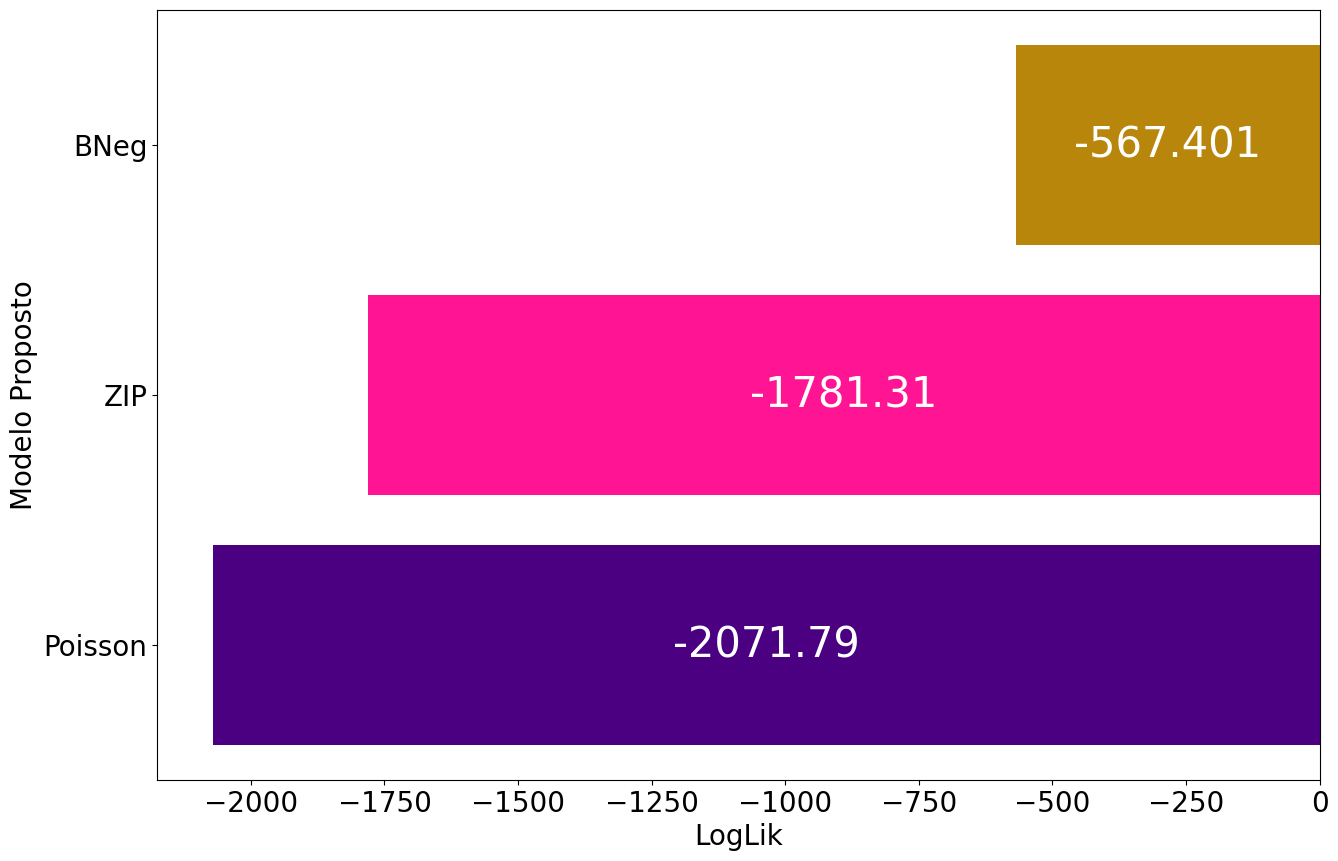

In [21]:
# Gráfico para a comparação dos LogLiks dos modelos Poisson,
# binomial negativo e ZIP

# Definição do dataframe com os modelos e respectivos LogLiks
df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_bneg.llf]})
df_llf

# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(15,10))

c = ['indigo', 'deeppink', 'darkgoldenrod']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
ax.set_ylabel("Modelo Proposto", fontsize=20)
ax.set_xlabel("LogLik", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()